In [1]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
trainFile = 'train/'
validFile = 'valid/'
testFile = 'test/'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=trainFile, target_size=(224,224), classes=['130','120','100','90','80','70','60','50','30'], batch_size=38)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=validFile, target_size=(224,224), classes=['130','120','100','90','80','70','60','50','30'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=testFile, target_size=(224,224), classes=['130','120','100','90','80','70','60','50','30'], batch_size=2, shuffle=False)

Found 342 images belonging to 9 classes.
Found 90 images belonging to 9 classes.
Found 18 images belonging to 9 classes.


In [5]:
assert train_batches.n == 342
assert valid_batches.n == 90
assert test_batches.n == 18
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 9


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0.

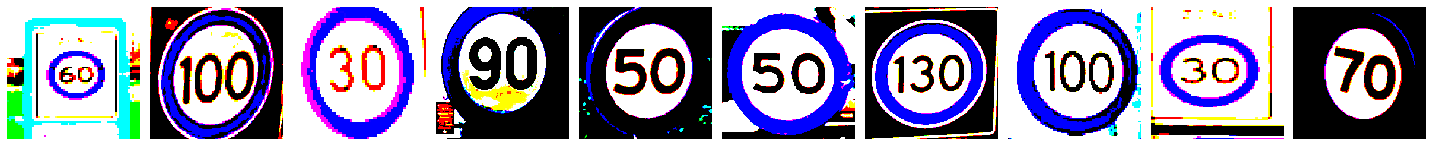

In [8]:
plotImages(imgs)
print(labels)

In [9]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=9, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 9)                 1806345   
Total params: 1,825,737
Trainable params: 1,825,737
Non-trainable params: 0
______________________________________________

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=300,
    verbose=2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 9 steps, validate for 9 steps
Epoch 1/300
9/9 - 5s - loss: 130.1108 - accuracy: 0.2164 - val_loss: 80.7333 - val_accuracy: 0.2667
Epoch 2/300
9/9 - 4s - loss: 58.0463 - accuracy: 0.3333 - val_loss: 61.6673 - val_accuracy: 0.2444
Epoch 3/300
9/9 - 4s - loss: 22.7568 - accuracy: 0.5351 - val_loss: 34.4164 - val_accuracy: 0.2667
Epoch 4/300
9/9 - 4s - loss: 8.5863 - accuracy: 0.6784 - val_loss: 22.9840 - val_accuracy: 0.3889
Epoch 5/300
9/9 - 4s - loss: 3.3016 - accuracy: 0.8363 - val_loss: 20.8717 - val_accuracy: 0.3778
Epoch 6/300
9/9 - 4s - loss: 1.4297 - accuracy: 0.8830 - val_loss: 14.3873 - val_accuracy: 0.4333
Epoch 7/300
9/9 - 4s - loss: 0.2432 - accuracy: 0.9766 - val_loss: 13.2303 - val_accuracy: 0.4778
Epoch 8/300
9/9 - 4s - loss: 0.0588 - accuracy: 0.9854 - val_loss: 13.4497 - val_accuracy: 0.4556
Epoch 9/300
9/9 - 4s - loss: 0.0291 - accuracy: 0.9912 - val_loss: 13.0178 - val_accuracy: 0.4333
Epoch 10/300
9/9 - 4s - 

Epoch 79/300
9/9 - 4s - loss: 1.9860e-06 - accuracy: 1.0000 - val_loss: 11.4304 - val_accuracy: 0.4556
Epoch 80/300
9/9 - 4s - loss: 1.9571e-06 - accuracy: 1.0000 - val_loss: 11.4302 - val_accuracy: 0.4556
Epoch 81/300
9/9 - 4s - loss: 1.9247e-06 - accuracy: 1.0000 - val_loss: 11.4299 - val_accuracy: 0.4556
Epoch 82/300
9/9 - 4s - loss: 1.9048e-06 - accuracy: 1.0000 - val_loss: 11.4296 - val_accuracy: 0.4556
Epoch 83/300
9/9 - 4s - loss: 1.8682e-06 - accuracy: 1.0000 - val_loss: 11.4294 - val_accuracy: 0.4556
Epoch 84/300
9/9 - 4s - loss: 1.8452e-06 - accuracy: 1.0000 - val_loss: 11.4291 - val_accuracy: 0.4556
Epoch 85/300
9/9 - 4s - loss: 1.8191e-06 - accuracy: 1.0000 - val_loss: 11.4288 - val_accuracy: 0.4556
Epoch 86/300
9/9 - 4s - loss: 1.7874e-06 - accuracy: 1.0000 - val_loss: 11.4287 - val_accuracy: 0.4556
Epoch 87/300
9/9 - 4s - loss: 1.7689e-06 - accuracy: 1.0000 - val_loss: 11.4284 - val_accuracy: 0.4556
Epoch 88/300
9/9 - 4s - loss: 1.7435e-06 - accuracy: 1.0000 - val_loss: 1

Epoch 158/300
9/9 - 4s - loss: 8.7140e-07 - accuracy: 1.0000 - val_loss: 11.4171 - val_accuracy: 0.4556
Epoch 159/300
9/9 - 4s - loss: 8.6548e-07 - accuracy: 1.0000 - val_loss: 11.4170 - val_accuracy: 0.4556
Epoch 160/300
9/9 - 4s - loss: 8.5606e-07 - accuracy: 1.0000 - val_loss: 11.4169 - val_accuracy: 0.4556
Epoch 161/300
9/9 - 4s - loss: 8.5153e-07 - accuracy: 1.0000 - val_loss: 11.4168 - val_accuracy: 0.4556
Epoch 162/300
9/9 - 4s - loss: 8.4491e-07 - accuracy: 1.0000 - val_loss: 11.4167 - val_accuracy: 0.4556
Epoch 163/300
9/9 - 4s - loss: 8.4038e-07 - accuracy: 1.0000 - val_loss: 11.4165 - val_accuracy: 0.4556
Epoch 164/300
9/9 - 4s - loss: 8.3097e-07 - accuracy: 1.0000 - val_loss: 11.4164 - val_accuracy: 0.4556
Epoch 165/300
9/9 - 4s - loss: 8.2504e-07 - accuracy: 1.0000 - val_loss: 11.4163 - val_accuracy: 0.4556
Epoch 166/300
9/9 - 4s - loss: 8.2051e-07 - accuracy: 1.0000 - val_loss: 11.4162 - val_accuracy: 0.4556
Epoch 167/300
9/9 - 4s - loss: 8.1319e-07 - accuracy: 1.0000 - v

Epoch 237/300
9/9 - 4s - loss: 5.1378e-07 - accuracy: 1.0000 - val_loss: 11.4088 - val_accuracy: 0.4556
Epoch 238/300
9/9 - 4s - loss: 5.1064e-07 - accuracy: 1.0000 - val_loss: 11.4087 - val_accuracy: 0.4556
Epoch 239/300
9/9 - 4s - loss: 5.0716e-07 - accuracy: 1.0000 - val_loss: 11.4087 - val_accuracy: 0.4556
Epoch 240/300
9/9 - 4s - loss: 5.0542e-07 - accuracy: 1.0000 - val_loss: 11.4085 - val_accuracy: 0.4556
Epoch 241/300
9/9 - 4s - loss: 5.0158e-07 - accuracy: 1.0000 - val_loss: 11.4084 - val_accuracy: 0.4556
Epoch 242/300
9/9 - 4s - loss: 4.9775e-07 - accuracy: 1.0000 - val_loss: 11.4083 - val_accuracy: 0.4556
Epoch 243/300
9/9 - 4s - loss: 4.9496e-07 - accuracy: 1.0000 - val_loss: 11.4082 - val_accuracy: 0.4556
Epoch 244/300
9/9 - 4s - loss: 4.9217e-07 - accuracy: 1.0000 - val_loss: 11.4081 - val_accuracy: 0.4556
Epoch 245/300
9/9 - 4s - loss: 4.8973e-07 - accuracy: 1.0000 - val_loss: 11.4080 - val_accuracy: 0.4556
Epoch 246/300
9/9 - 4s - loss: 4.8624e-07 - accuracy: 1.0000 - v

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]


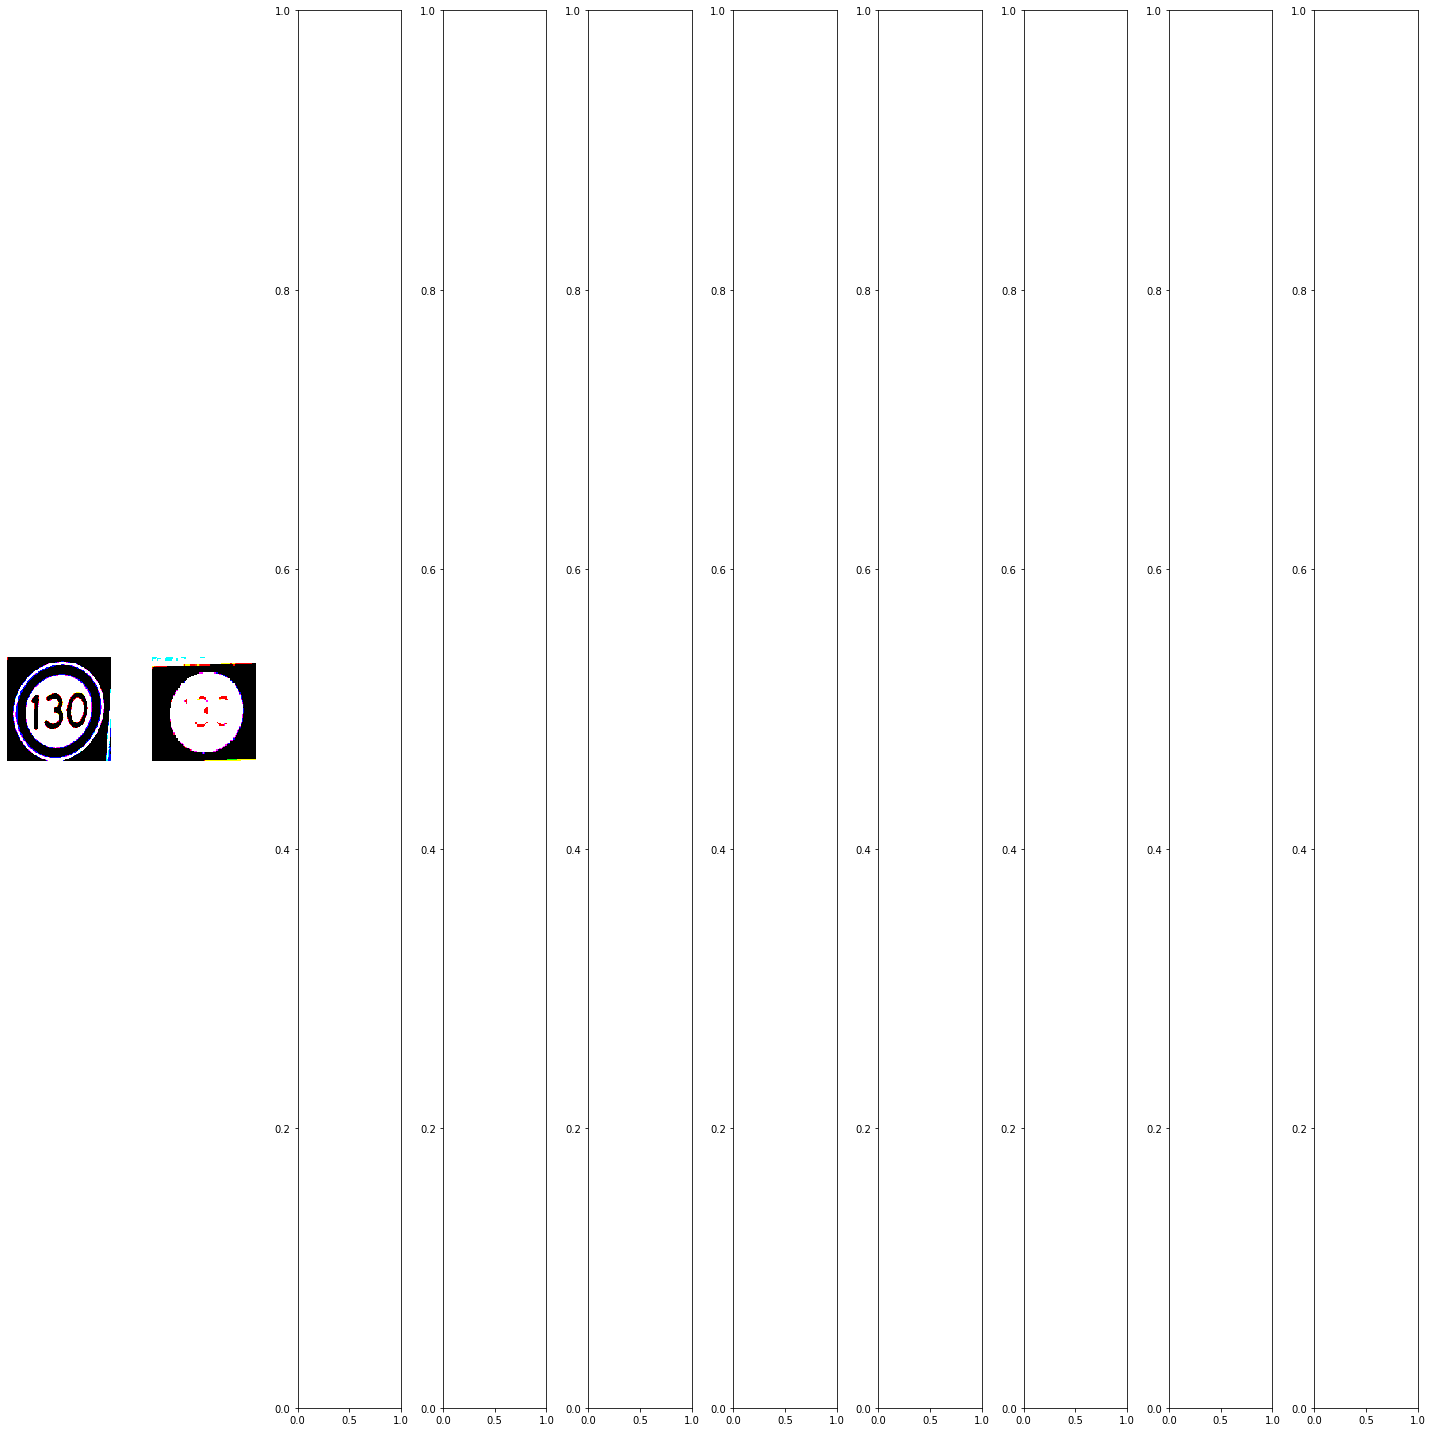

In [13]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [14]:
test_batches.classes


array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8])

In [15]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
np.round(predictions)
for i in predictions:
    print(np.round(i))
   



[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [21]:
import os.path
modelNum = 1
savedModel = False
model_path = "Model"+str(modelNum)+".h5"
while not savedModel:
    if os.path.isfile(model_path) is False:
        model.save(model_path)
        savedModel = True
    else:
        num += 1
    
#model.get_weights()

PREDICTION: 30


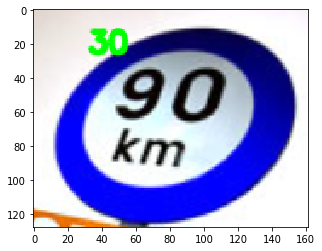

PREDICTION: 100


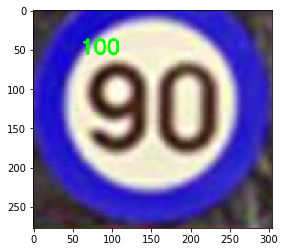

PREDICTION: 100


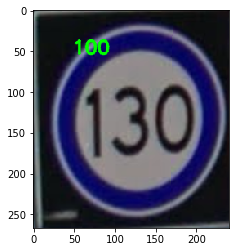

PREDICTION: 100


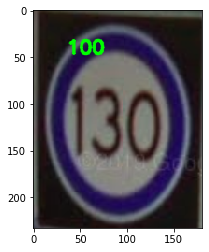

PREDICTION: 100


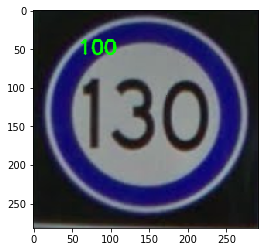

PREDICTION: 100


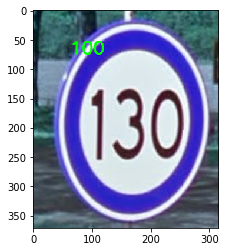

PREDICTION: 100


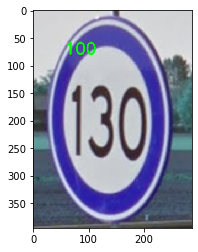

PREDICTION: 120


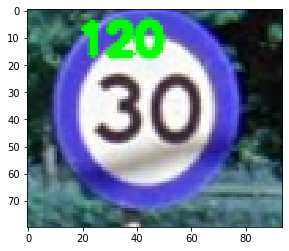

PREDICTION: 70


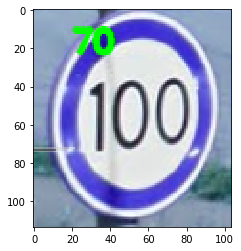

PREDICTION: 70


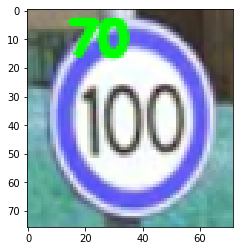

PREDICTION: 70


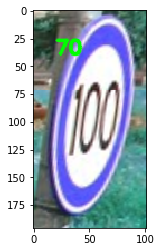

PREDICTION: 100


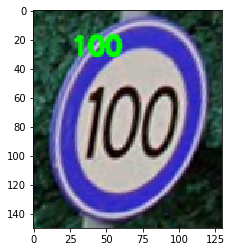

PREDICTION: 70


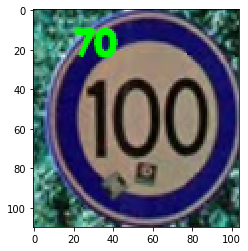

PREDICTION: 100


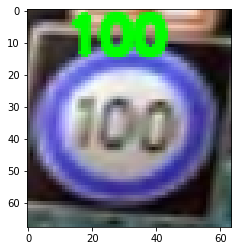

PREDICTION: 100


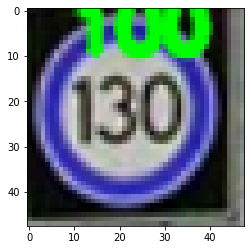

PREDICTION: 100


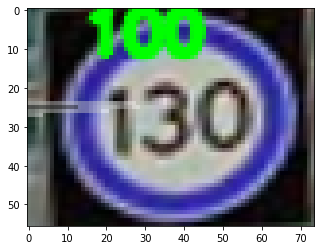

PREDICTION: 100


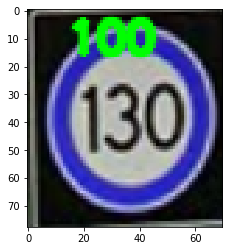

PREDICTION: 70


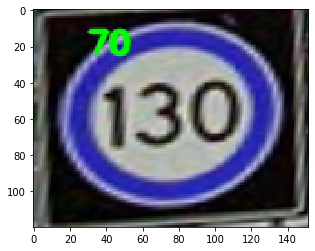

PREDICTION: 30


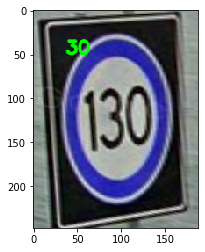

PREDICTION: 30


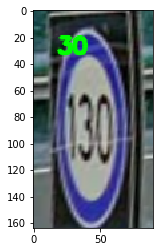

PREDICTION: 30


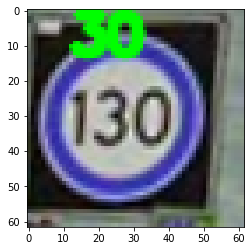

PREDICTION: 120


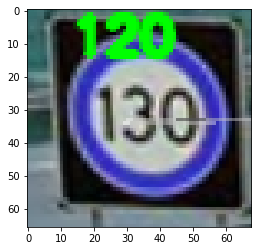

PREDICTION: 70


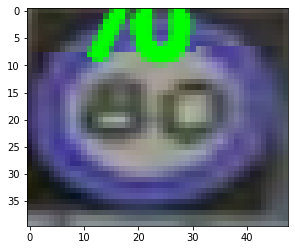

PREDICTION: 70


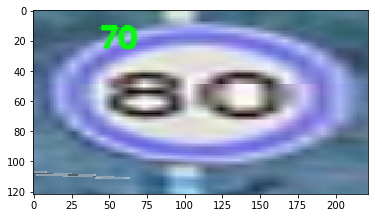

PREDICTION: 120


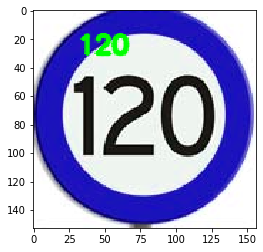

In [22]:
TSclasses = ['130','120','100','90','80','70','60','50','30']
def prepare(filepath):
    IMG_SIZE = 224
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE),3)
    return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,3)


imgNum = 0

testFile = "test/all_classes/"
for i in os.listdir(testFile):
    imgNum += 1
    imgPath = testFile+i
    img = cv2.imread(imgPath)

    prediction = model.predict([prepare(imgPath)])
    maxPred = max(prediction[0])
    x = np.where(prediction[0] ==maxPred)
    x = x[0][0]
    #print("INDEX:",x)

    #print(np.round(prediction))
    print("PREDICTION:",TSclasses[x])
    txt = "PREDICTION: "+ TSclasses[x]
    
    height, width, channels = img.shape 
    fontScale = (width * height)/(500 * 500)+0.5
    height = 0 + (height//5)
    width = 0 + (width//5)
    cv2.putText(img, TSclasses[x] , (width,height), cv2.FONT_HERSHEY_SIMPLEX,fontScale, (0, 255, 0), 2, cv2.LINE_AA)
    plt.imshow(img)
    plt.show()
    newImgPath = "/predictions/Model"+str(modelNum)+"_Test"+str(imgNum)+".png"
    cv2.imwrite(newImgPath, img)


#a = np.array(TSclasses)
#x = np.where(a ==1.)
#print("INDEX:",x)